In [1]:
# Import qiskit

import qiskit

In [2]:
# Check qiskit has imported prooperly and what version we're using

qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

In [3]:
# Import all the necessary libraries (not all libraries are necessary but this is what Mohammed had)

from qiskit.aqua.algorithms import VQE, NumPyEigensolver,NumPyMinimumEigensolver
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries, MatrixOp
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from qiskit.aqua.operators import (TPBGroupedWeightedPauliOperator,
                                  WeightedPauliOperator,
                                  MatrixOperator)
import warnings
import time

In [4]:
# Import the Hamiltonian from my Mathematica .txt file (which I uploaded to my Jupyter files)

start_time = time.time()
warnings.filterwarnings("ignore")
file_path = fr'./Hdarkenergyosc32x32.txt'
H_file = np.loadtxt(file_path)

HH = MatrixOp(primitive=H_file)
HHH = HH.to_pauli_op()
qubitOp = HHH.to_legacy_op()

# Print some items that gives us info on the Hamiltonian so that we known we did the above step correctly
# Info such as size of Hamiltonian (16x16), number of qubits (4), and how the Hamiltonian is mapped onto the qubits
# It includes the identity matrix, I (beginning of each thing), X gates, Y gates, and Z gates (created in strings in order
# to represnet Hamiltonian)

print("Size of Hamiltonian:", np.shape(H_file))
print(qubitOp)
print(qubitOp.print_details())
type(qubitOp)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:', runtime)

Size of Hamiltonian: (32, 32)
Representation: paulis, qubits: 5, size: 447
IIIII	(68.82626126998395+0j)
IIIIX	(-47.6213005150847+0j)
IIIXI	(19.599238057311467+0j)
IIIXX	(-28.114317871007735+0j)
IIIXZ	(-0.42056718281529903+0j)
IIIYY	(-20.657368417152156+0j)
IIIZI	(-1.4832208807904976+0j)
IIIZX	(1.6683713307739225+0j)
IIIZZ	(-1.767386327863317+0j)
IIXII	(1.7328319722265402+0j)
IIXIX	(-3.9274587314144442+0j)
IIXIZ	(-0.0770254381897928+0j)
IIXXI	(9.95375595066374+0j)
IIXXX	(-14.188289209497981+0j)
IIXXZ	(-0.37147404649549287+0j)
IIXYY	(10.266822638787115+0j)
IIXZI	(-0.16437756066291265+0j)
IIXZX	(0.34148322818214094+0j)
IIXZZ	(-0.004653703519178043+0j)
IIYIY	(-3.6113031492922145+0j)
IIYXY	(-10.422428786580106+0j)
IIYYI	(9.905619851791698+0j)
IIYYX	(-14.026401209216964+0j)
IIYYZ	(-0.36863336813828385+0j)
IIYZY	(0.30759701996131095+0j)
IIZII	(-5.0911970322817535+0j)
IIZIX	(4.542922599507223+0j)
IIZIZ	(-1.7470705622714193+0j)
IIZXI	(-2.619647074008539+0j)
IIZXX	(3.4051466205623506+0j)
IIZXZ	(

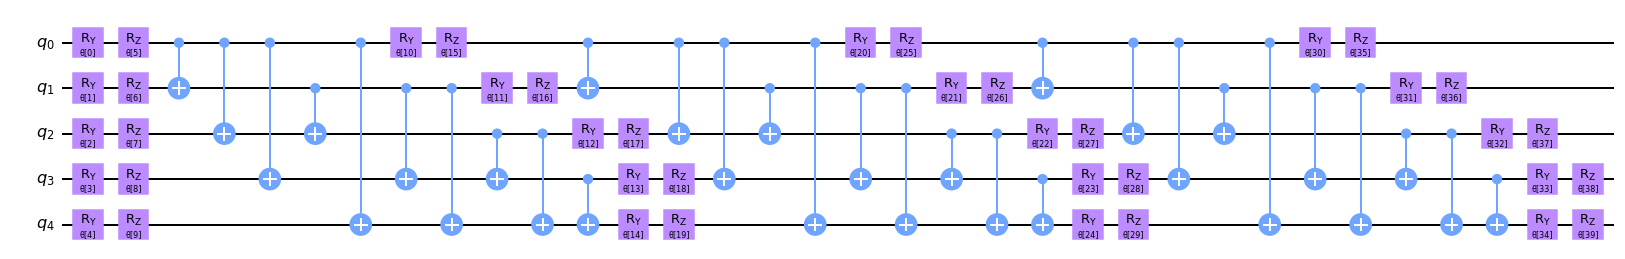

In [5]:
# Next, create the variational form using the function EfficientSU2 (ry variational form)
# Full entanglement means each qubit is entangled with all the other qubits with a c-not gate
# Reps is the depth of the circuit so each variational form is repeated 3 times (see below 3 sections of blue)

var_form = EfficientSU2(qubitOp.num_qubits,su2_gates=['ry','rz'],entanglement='full',reps=3)

# Display the variational form so that we can see the effect
display(var_form.draw(output='mpl',fold=100))

In [6]:
# Check the exact result that we're getting is correct (i.e. the minimum eigenvalue we'd expect)
# Example: for the SHO we'd expect to get 0.5

exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [0.00285585]


In [42]:
# This is the VQE algorithm; it takes a while to run sometimes

start_time = time.time()
warnings.filterwarnings("ignore")

# We have to choose a backend and in our case we're using the statevector simulator backend so we define it like this
backend = BasicAer.get_backend("statevector_simulator")
optimizer = SLSQP(maxiter=1000)

# We want to store some data for the plots later
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# When we want to run our VQE algorithm, we create an object which is an instance of the VQE class
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

# To run the VQE algorithm we use this line of code (this method), where the argument is the backend that we want
ret = vqe.run(backend)

vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:', runtime, "s")

VQE Result: 0.6354676965773742
Program runtime: 130.78092861175537 s


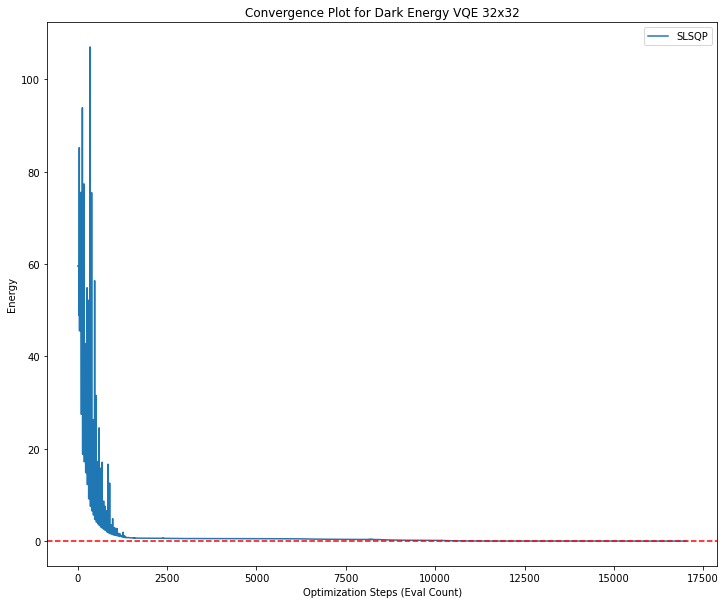

In [37]:
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SLSQP")
plt.xlabel('Optimization Steps (Eval Count)')
plt.ylabel('Energy')
plt.title('Convergence Plot for Dark Energy VQE 32x32')
plt.legend(loc='upper right')
plt.axhline(np.real(exact_solution.eigenvalues), color='red', linestyle='--')